# SR Infrence

use trained weights to super-resolution a new lores depth and hires DEM pair of arbitrary shape.

Also compute perofrmance metrics against a validation depth raster

In [1]:
# need this for CLI runs
import os
from pathlib import Path

VERBOSE = os.getenv('VERBOSE', '1').strip().lower() not in {'0', 'false', 'no', 'off'}
print(f"VERBOSE={int(VERBOSE)}")

PROJECT_ROOT = Path(os.getenv('PROJECT_ROOT', '/workspace')).resolve()
if not PROJECT_ROOT.exists():
    PROJECT_ROOT = Path.cwd().resolve()

os.chdir(PROJECT_ROOT)
print(f"cwd set to {Path.cwd()}")


VERBOSE=1
cwd set to /workspace


In [2]:
# Standard library + scientific stack used throughout inference notebook.
import os
from pathlib import Path
import math
import json

import numpy as np
import pandas as pd
import rasterio


import matplotlib.pyplot as plt


In [3]:
# Reuse shared preprocessing and diagnostics helpers from training code.
from t02.tools_train import (
    extract_sr_dem_prediction_np,
    invert_depth_log1p_np,
    normalize_dem,
    prepare_sr_dem_model_inputs_np,
    resize_bilinear_2d_np,
    scale_depth_log1p_np,
)
import t02.results as results


2026-02-19 15:54:26.762517: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-19 15:54:26.762558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-19 15:54:26.763334: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


define raster paths

In [4]:
# Input rasters for DEM-conditioned super-resolution inference.
# Paths can be overridden via env vars for HTCondor / CLI runs.

def _env_path(var_name, default):
    value = os.getenv(var_name, '').strip()
    return Path(value) if value else Path(default)

def _env_flag(var_name, default=True):
    value = os.getenv(var_name)
    if value is None:
        return default
    value = value.strip().lower()
    if value == '':
        return default
    return value in {'1', 'true', 'yes', 'y', 'on'}

dem_fp = _env_path('INFER_DEM_FP', '_inputs/RSSHydro/dudelange/002/DEM.tif')
depth_lores_fp = _env_path('INFER_DEPTH_LR_FP', '_inputs/RSSHydro/dudelange/032/ResultA.tif')
depth_hires_valid_fp = _env_path('INFER_DEPTH_HR_FP', '_inputs/RSSHydro/dudelange/002/ResultA.tif')
write_inference_tiff = _env_flag('WRITE_INFERENCE_TIFF', default=True)

print(f"INFER_DEM_FP={dem_fp}")
print(f"INFER_DEPTH_LR_FP={depth_lores_fp}")
print(f"INFER_DEPTH_HR_FP={depth_hires_valid_fp}")
print(f"WRITE_INFERENCE_TIFF={int(write_inference_tiff)}")

assert dem_fp.exists(), f"DEM file not found: {dem_fp}"
assert depth_lores_fp.exists(), f"Lo-res depth file not found: {depth_lores_fp}"
assert depth_hires_valid_fp.exists(), f"Hi-res validation depth file not found: {depth_hires_valid_fp}"


INFER_DEM_FP=_inputs/RSSHydro/dudelange/002/DEM.tif
INFER_DEPTH_LR_FP=_inputs/RSSHydro/dudelange/032/ResultA.tif
INFER_DEPTH_HR_FP=_inputs/RSSHydro/dudelange/002/ResultA.tif
WRITE_INFERENCE_TIFF=1


In [5]:
# Load inference artifact and preprocessing metadata.
# The shared training runner (`t02/tools_train.py`) exports `model_infer.keras`
# after loading best validation-loss weights,
# so this file can be treated as the best checkpoint for inference.
train_dir_env = os.getenv('TRAIN_DIR', '').strip()
model_env = os.getenv('INFER_MODEL_FP', '').strip()

if model_env:
    model_fp = Path(model_env)
elif train_dir_env:
    model_fp = Path(train_dir_env) / 'model_infer.keras'
else:
    model_fp = Path('train_outputs/4690176_0_1770580046_train_base_16/train_run/model_infer.keras')

print(f"INFER_MODEL_FP={model_fp}")
assert model_fp.exists(), f"Model file not found: {model_fp}"


INFER_MODEL_FP=train_outputs/4690176_0_1770580046_train_base_16/train_run/model_infer.keras


In [6]:
# Inference-only runtime knobs.
# Model/preprocessing parameters are loaded from train_config.json in the next cell.
WINDOW_METHOD = os.getenv("INFER_WINDOW_METHOD", "feather").strip().lower() or "feather"

# Optional override for feather overlap in LR pixels (blank => derive from LR_TILE).
feather_overlap_lr_env = os.getenv("INFER_FEATHER_OVERLAP_LR", "").strip()
FEATHER_OVERLAP_LR = int(feather_overlap_lr_env) if feather_overlap_lr_env else None

# Keep dry/wet threshold aligned with training diagnostics.
DRY_DEPTH_THRESH_M = results.DEFAULT_DRY_DEPTH_THRESH_M

print(f"Runtime config: WINDOW_METHOD={WINDOW_METHOD}, FEATHER_OVERLAP_LR={FEATHER_OVERLAP_LR}")


Runtime config: WINDOW_METHOD=feather, FEATHER_OVERLAP_LR=None


### model weights

see `t02/SR_ResUNet_DEM.ipynb` for training pipeline

In [24]:
# Load model/preprocessing geometry directly from training metadata.
train_config_fp = model_fp.parent / "train_config.json"
if not train_config_fp.exists():
    raise FileNotFoundError(f"train_config.json not found at {train_config_fp}")

train_cfg = json.loads(train_config_fp.read_text())
print(f"Loaded train config from {train_config_fp}")

# Required train-time parameters for consistent inference.
required_keys = {"upscale", "input_shape", "max_depth"}
missing_keys = sorted(required_keys.difference(train_cfg.keys()))
if missing_keys:
    raise KeyError(f"train_config missing required keys: {missing_keys}")

# Geometry comes from the trained model config.
SCALE = int(train_cfg["upscale"])
input_shape = train_cfg["input_shape"]
if not isinstance(input_shape, (list, tuple)) or len(input_shape) < 2:
    raise AssertionError(f"input_shape must have at least [h, w, ...]; got {input_shape}")

LR_TILE = int(input_shape[0])
lr_w = int(input_shape[1])
if LR_TILE != lr_w:
    raise AssertionError(f"input_shape must be square for tiled inference; got {input_shape}")
HR_TILE = LR_TILE * SCALE

# Preprocessing parameters come from the same train config.
MAX_DEPTH = float(train_cfg["max_depth"])

dem_stats_cfg = train_cfg.get("dem_stats")
if train_cfg.get("dem_pct_clip") is not None:
    DEM_PCT_CLIP = float(train_cfg["dem_pct_clip"])
elif isinstance(dem_stats_cfg, dict) and dem_stats_cfg.get("p_clip") is not None:
    DEM_PCT_CLIP = float(dem_stats_cfg["p_clip"])
else:
    raise KeyError("train_config must include dem_pct_clip or dem_stats.p_clip")

# Reuse train DEM min/max when available; otherwise compute per-raster at inference.
DEM_REF_STATS = None
if isinstance(dem_stats_cfg, dict):
    required_dem_stats = {"p_clip", "dem_min", "dem_max"}
    if required_dem_stats.issubset(dem_stats_cfg.keys()):
        DEM_REF_STATS = {k: float(dem_stats_cfg[k]) for k in sorted(required_dem_stats)}
    else:
        print(
            "train_config.dem_stats missing dem_min/dem_max; "
            "using per-raster DEM normalization stats."
        )

# Display labels come from train metadata where available.
MODEL_NAME = str(train_cfg.get("model_name") or "Model").strip()
LOSS_LABEL = str(
    train_cfg.get("loss_plot_label")
    or train_cfg.get("loss_label")
    or train_cfg.get("loss_name")
    or "Loss"
).strip()
MODEL_SERIES_LABEL = f"SR ({MODEL_NAME})"

# Feather overlap defaults to one-quarter tile width in LR pixels.
if FEATHER_OVERLAP_LR is None:
    FEATHER_OVERLAP_LR = max(1, LR_TILE // 4)

# Guardrails to catch config mismatches early.
assert SCALE > 0, f"SCALE must be > 0; got {SCALE}"
assert LR_TILE > 0, f"LR_TILE must be > 0; got {LR_TILE}"
assert HR_TILE == LR_TILE * SCALE, (
    f"HR_TILE must equal LR_TILE*SCALE; got HR_TILE={HR_TILE}, LR_TILE={LR_TILE}, SCALE={SCALE}"
)
assert MAX_DEPTH > 0, f"MAX_DEPTH must be > 0; got {MAX_DEPTH}"
assert WINDOW_METHOD in {"hard", "feather"}, f"Unsupported WINDOW_METHOD: {WINDOW_METHOD!r}"
assert 0 < DEM_PCT_CLIP <= 100, f"DEM_PCT_CLIP must be in (0, 100]; got {DEM_PCT_CLIP}"
assert 0 <= FEATHER_OVERLAP_LR < LR_TILE, (
    f"FEATHER_OVERLAP_LR must be in [0, {LR_TILE}); got {FEATHER_OVERLAP_LR}"
)
if WINDOW_METHOD == "feather":
    assert FEATHER_OVERLAP_LR > 0, "FEATHER_OVERLAP_LR must be > 0 when WINDOW_METHOD='feather'"

print("Resolved from train_config.json only:")
print(f"  geometry: SCALE={SCALE}, LR_TILE={LR_TILE}, HR_TILE={HR_TILE}")
print(f"  preprocessing: MAX_DEPTH={MAX_DEPTH}, DEM_PCT_CLIP={DEM_PCT_CLIP}")
print(f"  model label: {MODEL_SERIES_LABEL}")
print(f"  loss label: {LOSS_LABEL}")
print(f'    WINDOW_METHOD={WINDOW_METHOD}, FEATHER_OVERLAP_LR={FEATHER_OVERLAP_LR}')
if DEM_REF_STATS is not None:
    print(f"  DEM stats: {DEM_REF_STATS}")


Loaded train config from train_outputs/4690176_0_1770580046_train_base_16/train_run/train_config.json
train_config.dem_stats missing dem_min/dem_max; using per-raster DEM normalization stats.
Resolved from train_config.json only:
  geometry: SCALE=16, LR_TILE=32, HR_TILE=512
  preprocessing: MAX_DEPTH=5.0, DEM_PCT_CLIP=95.0
  model label: SR (ResUNet_DEM_16)
  loss label: MAE
    WINDOW_METHOD=feather, FEATHER_OVERLAP_LR=8


# Input Checks

In [8]:
# Raster I/O and validation helpers.
# These checks catch geospatial mismatches before model inference.
def _assert_square_pixels(src, name):
    res = src.res
    if not np.isclose(abs(res[0]), abs(res[1])):
        raise AssertionError(f"{name} pixels are not square: res={res}")


def _assert_bounds_close(a, b, name_a, name_b, tol=1e-6):
    if not all(np.isclose(av, bv, atol=tol) for av, bv in zip(a, b)):
        raise AssertionError(f"{name_a} bounds {a} != {name_b} bounds {b}")


def _assert_no_nodata(arr, name):
    if np.ma.isMaskedArray(arr) and np.any(arr.mask):
        raise AssertionError(f"{name} contains nodata/masked values")
    if np.isnan(np.asarray(arr)).any():
        raise AssertionError(f"{name} contains NaNs")


def _fmt_res(res_xy):
    return f"({res_xy[0]:.6g}, {res_xy[1]:.6g})"


def read_and_check_rasters(dem_fp, depth_lores_fp, depth_hires_fp):
    with (
        rasterio.open(dem_fp) as dem_src,
        rasterio.open(depth_lores_fp) as lr_src,
        rasterio.open(depth_hires_fp) as hr_src,
    ):
        # CRS and bounds checks: all inputs must be on the same grid/extent.
        if dem_src.crs != hr_src.crs or lr_src.crs != hr_src.crs:
            raise AssertionError("CRS mismatch between rasters")
        _assert_bounds_close(dem_src.bounds, hr_src.bounds, "DEM", "HR")
        _assert_bounds_close(lr_src.bounds, hr_src.bounds, "LR", "HR")

        _assert_square_pixels(dem_src, "DEM")
        _assert_square_pixels(lr_src, "LR")
        _assert_square_pixels(hr_src, "HR")

        # Read single-band rasters as masked arrays first to detect nodata explicitly.
        dem = dem_src.read(1, masked=True)
        lr = lr_src.read(1, masked=True)
        hr = hr_src.read(1, masked=True)

        _assert_no_nodata(dem, "DEM")
        _assert_no_nodata(lr, "LR depth")
        _assert_no_nodata(hr, "HR depth")

        dem = np.asarray(dem)
        lr = np.asarray(lr)
        hr = np.asarray(hr)

        if np.min(lr) < 0 or np.min(hr) < 0:
            raise AssertionError("Depth rasters contain negative values")
        if np.max(lr) > 15 or np.max(hr) > 15:
            raise AssertionError("Depth rasters exceed 15m max depth")
        if np.min(dem) < 0 or np.max(dem) > 5000:
            raise AssertionError("DEM raster outside expected range [0, 5000]")

        # Track geospatial resolution for later pre/post diagnostics.
        dem_res = (abs(float(dem_src.res[0])), abs(float(dem_src.res[1])))
        lr_res = (abs(float(lr_src.res[0])), abs(float(lr_src.res[1])))
        hr_res = (abs(float(hr_src.res[0])), abs(float(hr_src.res[1])))

        # Scale sanity (warn only): model expects a fixed LR->HR ratio.
        res_ratio_x = lr_res[0] / hr_res[0]
        res_ratio_y = lr_res[1] / hr_res[1]
        if not np.isclose(res_ratio_x, SCALE) or not np.isclose(res_ratio_y, SCALE):
            print(f"WARNING: LR/HR resolution ratio (x,y)=({res_ratio_x:.2f}, {res_ratio_y:.2f}) != SCALE={SCALE}.")
            print("         LR will be resampled to match model scale.")

        return dem, lr, hr, dem_src.profile, lr_src.profile, hr_src.profile, dem_res, lr_res, hr_res

# Read + validate rasters
dem_raw, lr_raw, hr_raw, dem_profile, lr_profile, hr_profile, dem_res, lr_res_raw, hr_res = read_and_check_rasters(
    dem_fp, depth_lores_fp, depth_hires_valid_fp
)

# Report raw geometry before any crop/resample/normalization.
raw_shape_scale = (hr_raw.shape[0] / lr_raw.shape[0], hr_raw.shape[1] / lr_raw.shape[1])
raw_res_scale = (lr_res_raw[0] / hr_res[0], lr_res_raw[1] / hr_res[1])
print(f"Raw shapes HR/LR: {hr_raw.shape} / {lr_raw.shape}")
print(f"Raw resolutions DEM/LR/HR: DEM={_fmt_res(dem_res)} LR={_fmt_res(lr_res_raw)} HR={_fmt_res(hr_res)}")
print(
    f"Raw HR:LR scale from shape (h,w)=({raw_shape_scale[0]:.2f}, {raw_shape_scale[1]:.2f}), "
    f"from resolution (x,y)=({raw_res_scale[0]:.2f}, {raw_res_scale[1]:.2f})"
)


         LR will be resampled to match model scale.
Raw shapes HR/LR: (2030, 2090) / (203, 209)
Raw resolutions DEM/LR/HR: DEM=(3, 3) LR=(30, 30) HR=(3, 3)
Raw HR:LR scale from shape (h,w)=(10.00, 10.00), from resolution (x,y)=(10.00, 10.00)


## plot raw inputs

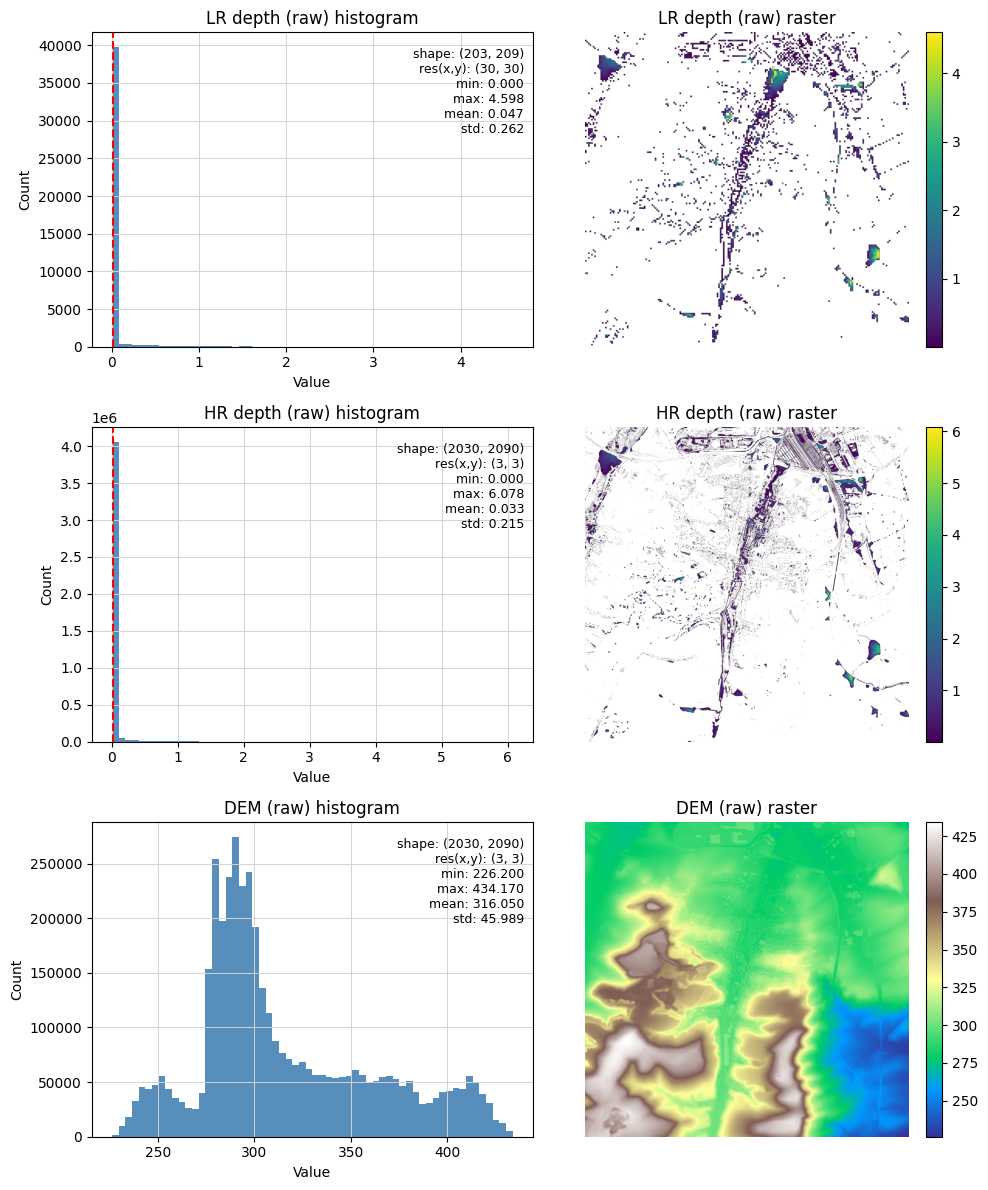

In [9]:
# Quick sanity plots for raw (un-normalized) inputs before preprocessing.

# Input diagnostics (raw): 2 columns (histogram, raster) x 3 rows (LR depth, HR depth, DEM)
plot_specs_raw = [
    ("LR depth (raw)", lr_raw, "viridis", True, DRY_DEPTH_THRESH_M, lr_res_raw),
    ("HR depth (raw)", hr_raw, "viridis", True, DRY_DEPTH_THRESH_M, hr_res),
    ("DEM (raw)", dem_raw, "terrain", False, None, dem_res),
]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

for row_idx, (title, arr, cmap, use_dry_mask, dry_thresh, res_xy) in enumerate(plot_specs_raw):
    arr = np.asarray(arr)
    vals = arr[np.isfinite(arr)]

    ax_hist = axes[row_idx, 0]
    ax_raster = axes[row_idx, 1]

    ax_hist.hist(vals, bins=60, color="steelblue", alpha=0.9)
    if use_dry_mask:
        ax_hist.axvline(dry_thresh, color="red", linestyle="--", linewidth=1.5)
    ax_hist.set_title(f"{title} histogram")
    ax_hist.set_xlabel("Value")
    ax_hist.set_ylabel("Count")
    ax_hist.grid(color="lightgrey", linestyle="-", linewidth=0.7)

    # Include geometry metadata directly in the histogram annotation.
    ax_hist.text(
        0.98,
        0.95,
        (
            f"shape: {arr.shape}\n"
            f"res(x,y): {_fmt_res(res_xy)}\n"
            f"min: {vals.min():.3f}\n"
            f"max: {vals.max():.3f}\n"
            f"mean: {vals.mean():.3f}\n"
            f"std: {vals.std():.3f}"
        ),
        transform=ax_hist.transAxes,
        fontsize=9,
        verticalalignment="top",
        horizontalalignment="right",
    )

    raster_arr = np.ma.masked_where(arr < dry_thresh, arr) if use_dry_mask else arr
    im = ax_raster.imshow(raster_arr, cmap=cmap)
    ax_raster.set_title(f"{title} raster")
    ax_raster.set_axis_off()
    fig.colorbar(im, ax=ax_raster, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


### pre-process validation raster

because our model was trained with a scale of 4, we need need to pre-process
to fit model constraints

In [10]:
# Use CPU for deterministic notebook inference/debugging.
import tensorflow as tf
#tf.config.set_visible_devices([], 'GPU')


In [11]:
# Preprocess rasters into model-ready normalized tensors.
# Capture geometry before crop/resample so pre/post comparisons are explicit.
pre_hr_shape = tuple(int(v) for v in hr_raw.shape)
pre_lr_shape = tuple(int(v) for v in lr_raw.shape)
pre_shape_scale = (pre_hr_shape[0] / pre_lr_shape[0], pre_hr_shape[1] / pre_lr_shape[1])
pre_res_scale = (lr_res_raw[0] / hr_res[0], lr_res_raw[1] / hr_res[1])

# Crop HR/DEM to be divisible by SCALE (avoids edge mismatches).
hr_h, hr_w = hr_raw.shape
crop_h = hr_h - (hr_h % SCALE)
crop_w = hr_w - (hr_w % SCALE)
if (crop_h, crop_w) != (hr_h, hr_w):
    print(f"Cropping HR/DEM from {(hr_h, hr_w)} to {(crop_h, crop_w)} for SCALE alignment")
hr_raw = hr_raw[:crop_h, :crop_w]
dem_raw = dem_raw[:crop_h, :crop_w]

# Depth normalization (clip -> log1p scale).
# This must match training exactly so model inputs are in-distribution.
sat_lr = float(np.mean(lr_raw >= MAX_DEPTH))
sat_hr = float(np.mean(hr_raw >= MAX_DEPTH))
print(f"Depth saturation @ MAX_DEPTH: LR={sat_lr:.2%}, HR={sat_hr:.2%}")

lr_raw = scale_depth_log1p_np(lr_raw, max_depth=MAX_DEPTH)
hr_raw = scale_depth_log1p_np(hr_raw, max_depth=MAX_DEPTH)

# DEM normalization: clip negatives, cap upper percentile, then min-max scale.
# Optionally reuse training DEM stats from train_config.json for consistency.
dem_norm, dem_stats = normalize_dem(dem_raw, pct_clip=DEM_PCT_CLIP, ref_stats=DEM_REF_STATS)
assert dem_norm is not None and dem_stats is not None
if DEM_REF_STATS is None:
    print("DEM stats computed from inference raster:", dem_stats)
else:
    print("DEM stats reused from train_config:", dem_stats)

# Resample LR depth to match HR/SCALE spatial size (bilinear).
# Resulting LR grid aligns with expected model input tile shape.
target_lr_h = crop_h // SCALE
target_lr_w = crop_w // SCALE
lr_norm = resize_bilinear_2d_np(lr_raw, (target_lr_h, target_lr_w), antialias=True)
lr_norm = np.clip(lr_norm, 0.0, 1.0)

# Derive the model-aligned LR resolution after explicit resampling.
lr_res_model = (hr_res[0] * SCALE, hr_res[1] * SCALE)

assert dem_norm.shape == hr_raw.shape
assert lr_norm.shape == (target_lr_h, target_lr_w)

# Report pre/post geometry and effective scale used by the model input.
post_shape_scale = (hr_raw.shape[0] / lr_norm.shape[0], hr_raw.shape[1] / lr_norm.shape[1])
post_res_scale = (lr_res_model[0] / hr_res[0], lr_res_model[1] / hr_res[1])
print("Pre-resample geometry:")
print(f"  shapes HR/LR: {pre_hr_shape} / {pre_lr_shape}")
print(f"  resolutions HR/LR: {_fmt_res(hr_res)} / {_fmt_res(lr_res_raw)}")
print(f"  scale from shape (h,w): ({pre_shape_scale[0]:.2f}, {pre_shape_scale[1]:.2f})")
print(f"  scale from resolution (x,y): ({pre_res_scale[0]:.2f}, {pre_res_scale[1]:.2f})")
print("Post-resample geometry (model input):")
print(f"  shapes HR/LR: {hr_raw.shape} / {lr_norm.shape}")
print(f"  resolutions HR/LR: {_fmt_res(hr_res)} / {_fmt_res(lr_res_model)}")
print(f"  scale from shape (h,w): ({post_shape_scale[0]:.2f}, {post_shape_scale[1]:.2f})")
print(f"  scale from resolution (x,y): ({post_res_scale[0]:.2f}, {post_res_scale[1]:.2f})")

# Pad to tile multiples for windowed inference.
# Padding avoids partial edge tiles; we crop back after prediction.
pad_h = (int(math.ceil(crop_h / HR_TILE)) * HR_TILE) - crop_h
pad_w = (int(math.ceil(crop_w / HR_TILE)) * HR_TILE) - crop_w

hr_pad = np.pad(hr_raw, ((0, pad_h), (0, pad_w)), mode="constant", constant_values=0.0)
dem_pad = np.pad(dem_norm, ((0, pad_h), (0, pad_w)), mode="constant", constant_values=0.0)
lr_pad = np.pad(
    lr_norm,
    ((0, pad_h // SCALE), (0, pad_w // SCALE)),
    mode="constant",
    constant_values=0.0,
)

# Verify padded geometry still reflects the configured scale.
pad_shape_scale = (hr_pad.shape[0] / lr_pad.shape[0], hr_pad.shape[1] / lr_pad.shape[1])
print("Padded shapes HR/LR:", hr_pad.shape, lr_pad.shape)
print(f"Padded HR:LR scale from shape (h,w)=({pad_shape_scale[0]:.2f}, {pad_shape_scale[1]:.2f}) (expected {SCALE})")


Cropping HR/DEM from (2030, 2090) to (2016, 2080) for SCALE alignment
Depth saturation @ MAX_DEPTH: LR=0.00%, HR=0.00%
DEM stats computed from inference raster: {'p_clip': 409.57021026611324, 'dem_min': 227.10000610351562, 'dem_max': 409.5702209472656}
Pre-resample geometry:
  shapes HR/LR: (2030, 2090) / (203, 209)
  resolutions HR/LR: (3, 3) / (30, 30)
  scale from shape (h,w): (10.00, 10.00)
  scale from resolution (x,y): (10.00, 10.00)
Post-resample geometry (model input):
  shapes HR/LR: (2016, 2080) / (126, 130)
  resolutions HR/LR: (3, 3) / (48, 48)
  scale from shape (h,w): (16.00, 16.00)
  scale from resolution (x,y): (16.00, 16.00)
Padded shapes HR/LR: (2048, 2560) (128, 160)
Padded HR:LR scale from shape (h,w)=(16.00, 16.00) (expected 16)


## plot normalized inputs

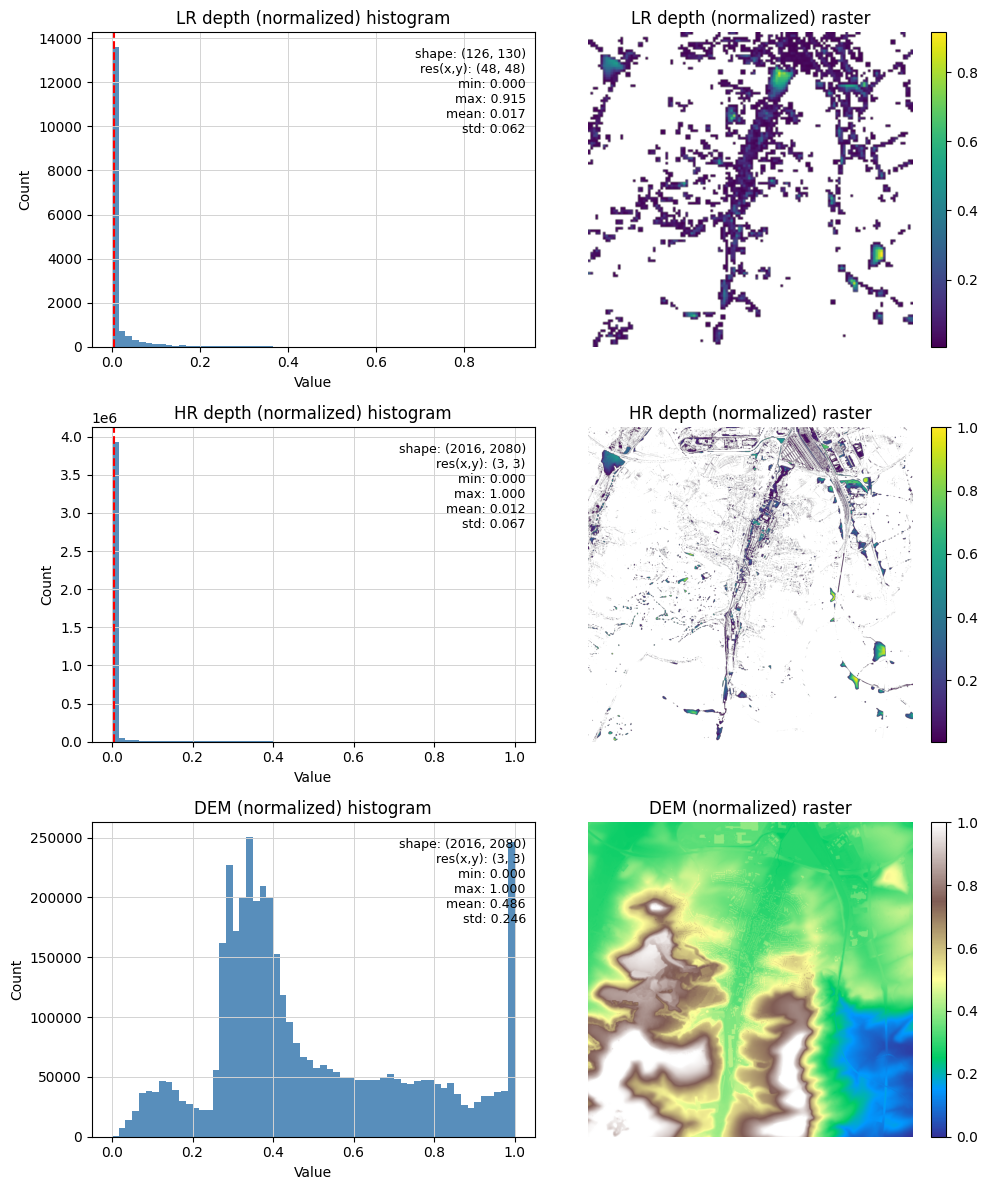

In [12]:
# Sanity plots after normalization to verify model-ready ranges/patterns.
# Input diagnostics: 2 columns (histogram, raster) x 3 rows (LR depth, HR depth, DEM)
dry_thresh_norm = float(scale_depth_log1p_np(np.array([DRY_DEPTH_THRESH_M], dtype=np.float32), max_depth=MAX_DEPTH)[0])
plot_specs = [
    ("LR depth (normalized)", lr_norm, "viridis", True, dry_thresh_norm, lr_res_model),
    ("HR depth (normalized)", hr_raw, "viridis", True, dry_thresh_norm, hr_res),
    ("DEM (normalized)", dem_norm, "terrain", False, None, hr_res),
]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

for row_idx, (title, arr, cmap, use_dry_mask, dry_thresh, res_xy) in enumerate(plot_specs):
    arr = np.asarray(arr)
    vals = arr[np.isfinite(arr)]

    ax_hist = axes[row_idx, 0]
    ax_raster = axes[row_idx, 1]

    ax_hist.hist(vals, bins=60, color="steelblue", alpha=0.9)
    if use_dry_mask:
        ax_hist.axvline(dry_thresh, color="red", linestyle="--", linewidth=1.5)
    ax_hist.set_title(f"{title} histogram")
    ax_hist.set_xlabel("Value")
    ax_hist.set_ylabel("Count")
    ax_hist.grid(color="lightgrey", linestyle="-", linewidth=0.7)

    # Include geometry metadata directly in the histogram annotation.
    ax_hist.text(
        0.98,
        0.95,
        (
            f"shape: {arr.shape}\n"
            f"res(x,y): {_fmt_res(res_xy)}\n"
            f"min: {vals.min():.3f}\n"
            f"max: {vals.max():.3f}\n"
            f"mean: {vals.mean():.3f}\n"
            f"std: {vals.std():.3f}"
        ),
        transform=ax_hist.transAxes,
        fontsize=9,
        verticalalignment="top",
        horizontalalignment="right",
    )

    raster_arr = np.ma.masked_where(arr < dry_thresh, arr) if use_dry_mask else arr
    im = ax_raster.imshow(raster_arr, cmap=cmap)
    ax_raster.set_title(f"{title} raster")
    ax_raster.set_axis_off()
    fig.colorbar(im, ax=ax_raster, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


# Per-chip inference and mosaicing strategy

This notebook predicts on fixed HR/LR chips, caches chip predictions, then assembles the full scene.

1. Non-overlap pass (`HR_TILE` stride) runs first to produce a simple chip mosaic and chip-level diagnostics.
2. Those predictions are cached by HR chip origin `(y0, x0)` so later steps can reuse them.
3. Final mosaic uses either:
   - `WINDOW_METHOD="hard"`: direct non-overlap mosaic from cached chips.
   - `WINDOW_METHOD="feather"`: overlapping windows with separable taper weights to reduce seams.
4. Feather overlap is configured in LR pixels (`FEATHER_OVERLAP_LR`) then converted to HR pixels (`overlap_hr = FEATHER_OVERLAP_LR * SCALE`).
5. After mosaicing, padded margins are cropped back to the valid HR extent.


In [13]:
# Load the exported inference model directly.
# This artifact already contains best validation-loss weights
# (see shared export logic in `t02/tools_train.py`).
model = results.load_inference_model(model_fp, compile=False)
model.trainable = False
print(f"Loaded model (best-weight export): {model_fp}")


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA RTX 4000 Ada Generation Laptop GPU, compute capability 8.9
Loaded model (best-weight export): train_outputs/4690176_0_1770580046_train_base_16/train_run/model_infer.keras


In [14]:
# Run per-chip inference first (no mosaicing), then build the full-scene mosaic.
hr_pad_h, hr_pad_w = hr_pad.shape


# Build tile start coordinates for a dimension and force trailing-edge coverage.
def build_tile_starts(total_size, tile_size, stride):
    starts = list(range(0, max(total_size - tile_size + 1, 1), stride))
    last_start = total_size - tile_size
    if starts[-1] != last_start:
        starts.append(last_start)
    return starts


# Cache predictions keyed by HR-grid origin so diagnostics/mosaic can reuse chips.
tile_pred_cache = {}


# Predict one tile: map HR origin -> LR origin, run model, cache normalized HR prediction.
def _predict_tile(y0, x0):
    key = (int(y0), int(x0))
    if key in tile_pred_cache:
        return tile_pred_cache[key]

    # Convert HR chip origin to LR chip origin with the fixed SCALE.
    lr_y0 = y0 // SCALE
    lr_x0 = x0 // SCALE

    # Slice aligned LR-depth and HR-DEM tiles.
    lr_tile = lr_pad[lr_y0 : lr_y0 + LR_TILE, lr_x0 : lr_x0 + LR_TILE]
    dem_tile = dem_pad[y0 : y0 + HR_TILE, x0 : x0 + HR_TILE]

    # Validate tile shapes and add batch dims expected by the model.
    lr_tile_batched, dem_tile_batched = prepare_sr_dem_model_inputs_np(
        depth_lr_norm=lr_tile,
        dem_hr_norm=dem_tile,
        expected_lr_shape=(LR_TILE, LR_TILE, 1),
        expected_hr_shape=(HR_TILE, HR_TILE, 1),
    )

    # Run inference and normalize output shape to (HR_TILE, HR_TILE).
    pred = model((lr_tile_batched, dem_tile_batched), training=False)
    pred_np = extract_sr_dem_prediction_np(pred, expected_hr_shape=(HR_TILE, HR_TILE, 1))
    tile_pred_cache[key] = pred_np
    return pred_np


In [15]:
# Step 1: non-overlap chip inference for diagnostics and cache priming.
# This pass gives one prediction per non-overlapping HR tile.
nonoverlap_y_starts = list(range(0, hr_pad_h, HR_TILE))
nonoverlap_x_starts = list(range(0, hr_pad_w, HR_TILE))
sr_pad_nonoverlap = np.zeros_like(hr_pad, dtype=np.float32)

print(
    f"Running simple non-overlap per-chip inference on "
    f"{len(nonoverlap_y_starts) * len(nonoverlap_x_starts)} chips..."
)
for y0 in nonoverlap_y_starts:
    for x0 in nonoverlap_x_starts:
        pred_np = _predict_tile(y0, x0)
        sr_pad_nonoverlap[y0 : y0 + HR_TILE, x0 : x0 + HR_TILE] = pred_np


# Build withheld-test-like chip stacks from fully valid (non-padded) tiles.
# These arrays feed the same diagnostics used in training_results.ipynb.
valid_tiles_h = crop_h // HR_TILE
valid_tiles_w = crop_w // HR_TILE
if valid_tiles_h == 0 or valid_tiles_w == 0:
    raise ValueError(
        f"No fully valid chips for diagnostics (crop={(crop_h, crop_w)}, HR_TILE={HR_TILE})."
    )

n_valid = valid_tiles_h * valid_tiles_w
lowres_chips = np.zeros((n_valid, LR_TILE, LR_TILE, 1), dtype=np.float32)
highres_chips = np.zeros((n_valid, HR_TILE, HR_TILE, 1), dtype=np.float32)
preds_chips = np.zeros((n_valid, HR_TILE, HR_TILE, 1), dtype=np.float32)
chip_coords = []

# Walk valid tile origins and collect aligned LR/HR/pred triplets.
chip_idx = 0
for ty in range(valid_tiles_h):
    y0 = ty * HR_TILE
    for tx in range(valid_tiles_w):
        x0 = tx * HR_TILE

        lr_y0 = y0 // SCALE
        lr_x0 = x0 // SCALE

        lowres_chips[chip_idx, ..., 0] = lr_pad[lr_y0 : lr_y0 + LR_TILE, lr_x0 : lr_x0 + LR_TILE]
        highres_chips[chip_idx, ..., 0] = hr_pad[y0 : y0 + HR_TILE, x0 : x0 + HR_TILE]
        preds_chips[chip_idx, ..., 0] = tile_pred_cache[(y0, x0)]
        chip_coords.append((y0, x0))
        chip_idx += 1

chip_coords = np.asarray(chip_coords, dtype=np.int32)
print(f"Prepared {chip_idx} valid chips ({valid_tiles_h} x {valid_tiles_w}) for diagnostics.")


Running simple non-overlap per-chip inference on 20 chips...
Prepared 12 valid chips (3 x 4) for diagnostics.


### PLOT: per-chip inference scatters

Chip baseline geometry: LR chip=(32, 32), HR chip=(512, 512), scale(h,w)=(16.00, 16.00)
Per-chip GLOBAL_METRICS[test]:
{
  "baseline": {
    "CSI": 0.20779991149902344,
    "CSI_001cm": 0.20779991149902344,
    "CSI_050cm": 0.03972312808036804,
    "CSI_100cm": 0.0,
    "MAE": 0.02219688892364502,
    "PSNR": 25.126806259155273,
    "RMSE": 0.06134419143199921,
    "RMSE_wet": 0.4696248471736908,
    "RMSE_wet_001cm": 0.17836813628673553,
    "RMSE_wet_050cm": 0.4696248471736908,
    "RMSE_wet_100cm": null,
    "SSIM": 0.7190445065498352
  },
  "best_epoch": {
    "CSI": 0.2382388561964035,
    "CSI_001cm": 0.2382388561964035,
    "CSI_050cm": 0.0,
    "CSI_100cm": 0.0,
    "MAE": 0.0163924191147089,
    "PSNR": 25.272035598754883,
    "RMSE": 0.059967946261167526,
    "RMSE_wet": 0.5568501949310303,
    "RMSE_wet_001cm": 0.20914797484874725,
    "RMSE_wet_050cm": 0.5568501949310303,
    "RMSE_wet_100cm": null,
    "SSIM": 0.789156973361969
  }
}


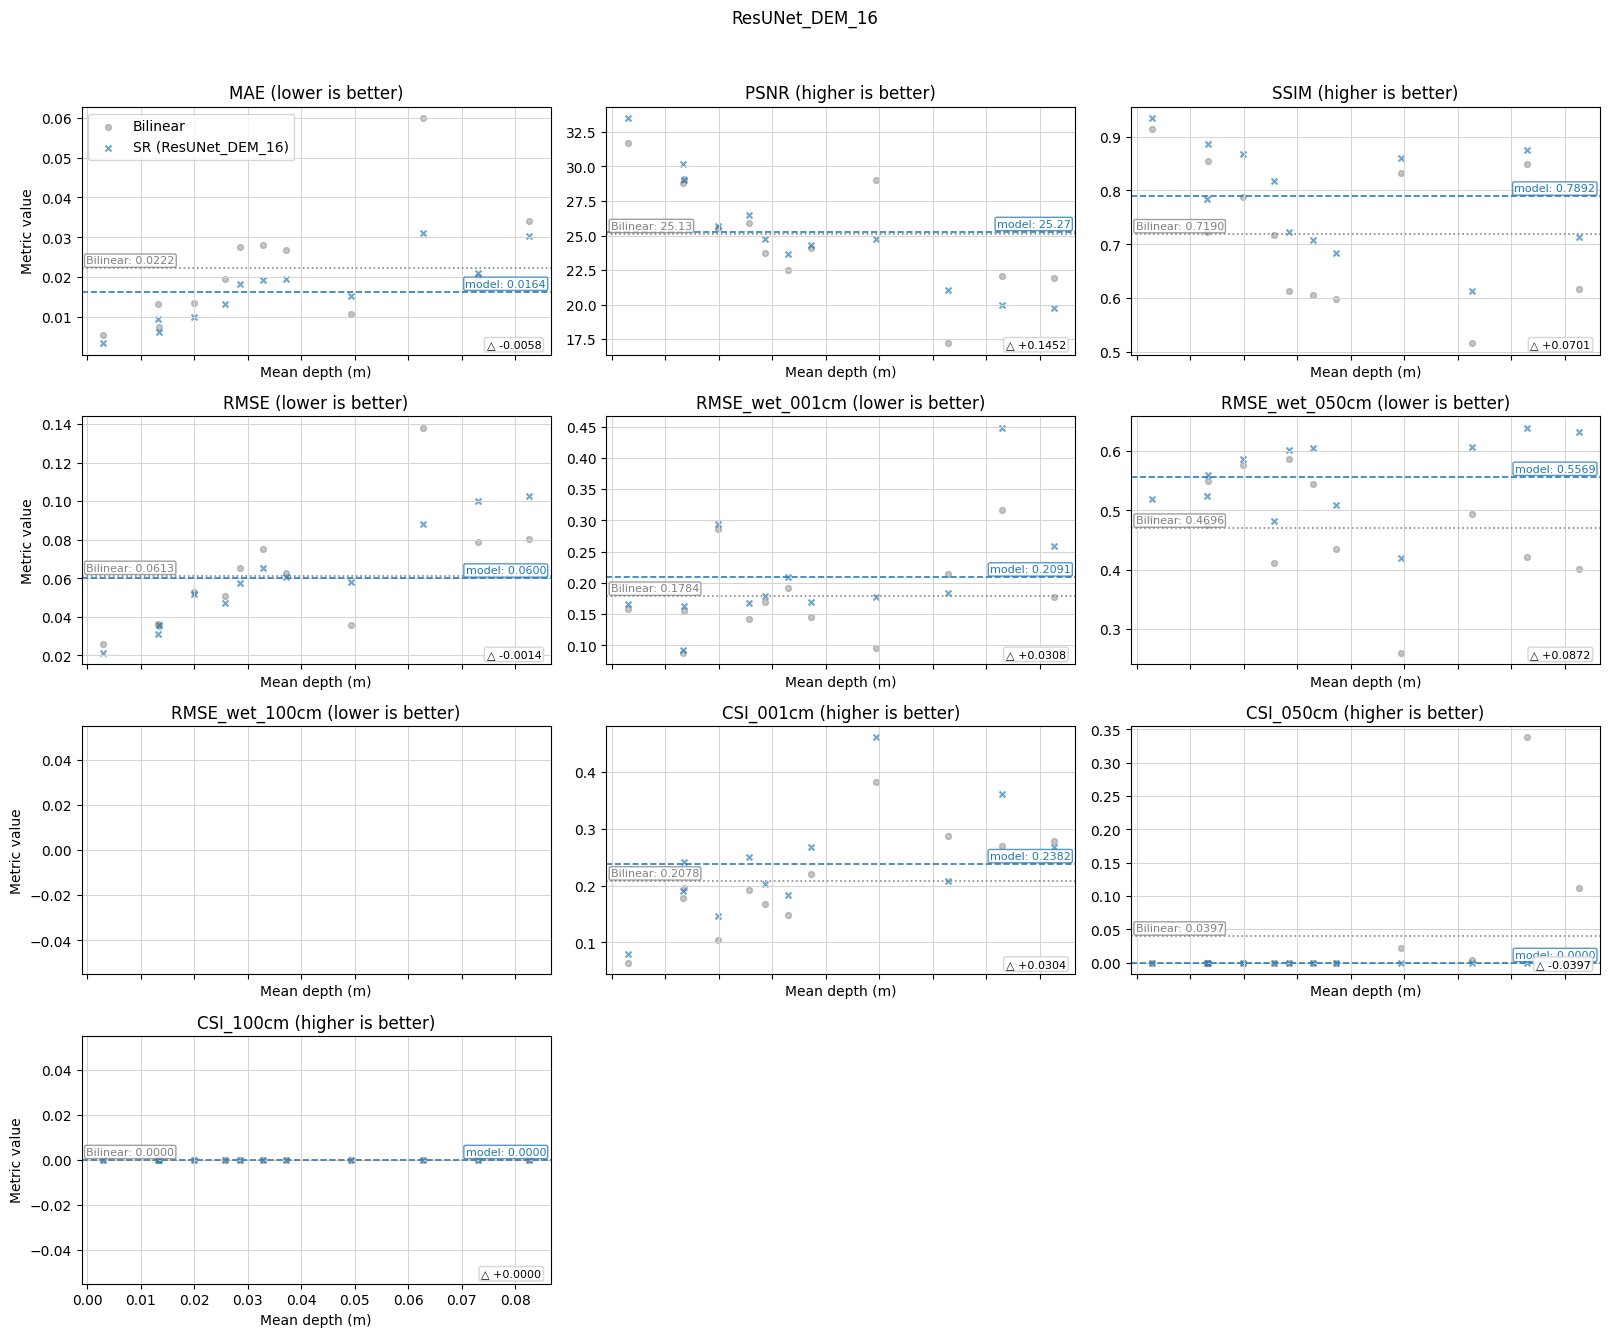

In [16]:
# Compute per-chip summary + per-sample metrics (model vs bilinear baseline).
chip_shape_scale = (
    highres_chips.shape[1] / lowres_chips.shape[1],
    highres_chips.shape[2] / lowres_chips.shape[2],
)
print(
    f"Chip baseline geometry: LR chip={lowres_chips.shape[1:3]}, HR chip={highres_chips.shape[1:3]}, "
    f"scale(h,w)=({chip_shape_scale[0]:.2f}, {chip_shape_scale[1]:.2f})"
)

chip_summary, chip_per_sample = results.evaluate_chip_arrays_vs_bilinear(
    lowres_chips=lowres_chips,
    highres_chips=highres_chips,
    preds_chips=preds_chips,
    max_depth=MAX_DEPTH,
    split_name='inference_chips',
    dry_depth_thresh_m=DRY_DEPTH_THRESH_M,
)

GLOBAL_METRICS = {'test': chip_summary}
PER_SAMPLE_METRICS = {'test': chip_per_sample}

print('Per-chip GLOBAL_METRICS[test]:')
print(json.dumps(GLOBAL_METRICS['test'], indent=2, sort_keys=True))


# Reproduce training_results.ipynb diagnostics on withheld-style chips.
test_samples = PER_SAMPLE_METRICS['test']

fig_scatter, _ = results.plot_metric_scatter_vs_mean_depth(
    test_samples,
    model_label=MODEL_SERIES_LABEL,
    baseline_label='Bilinear',
    split_summary=GLOBAL_METRICS.get('test'),
    model_name=MODEL_NAME,
    loss_plot_label=LOSS_LABEL,
)
plt.show()
plt.close(fig_scatter)


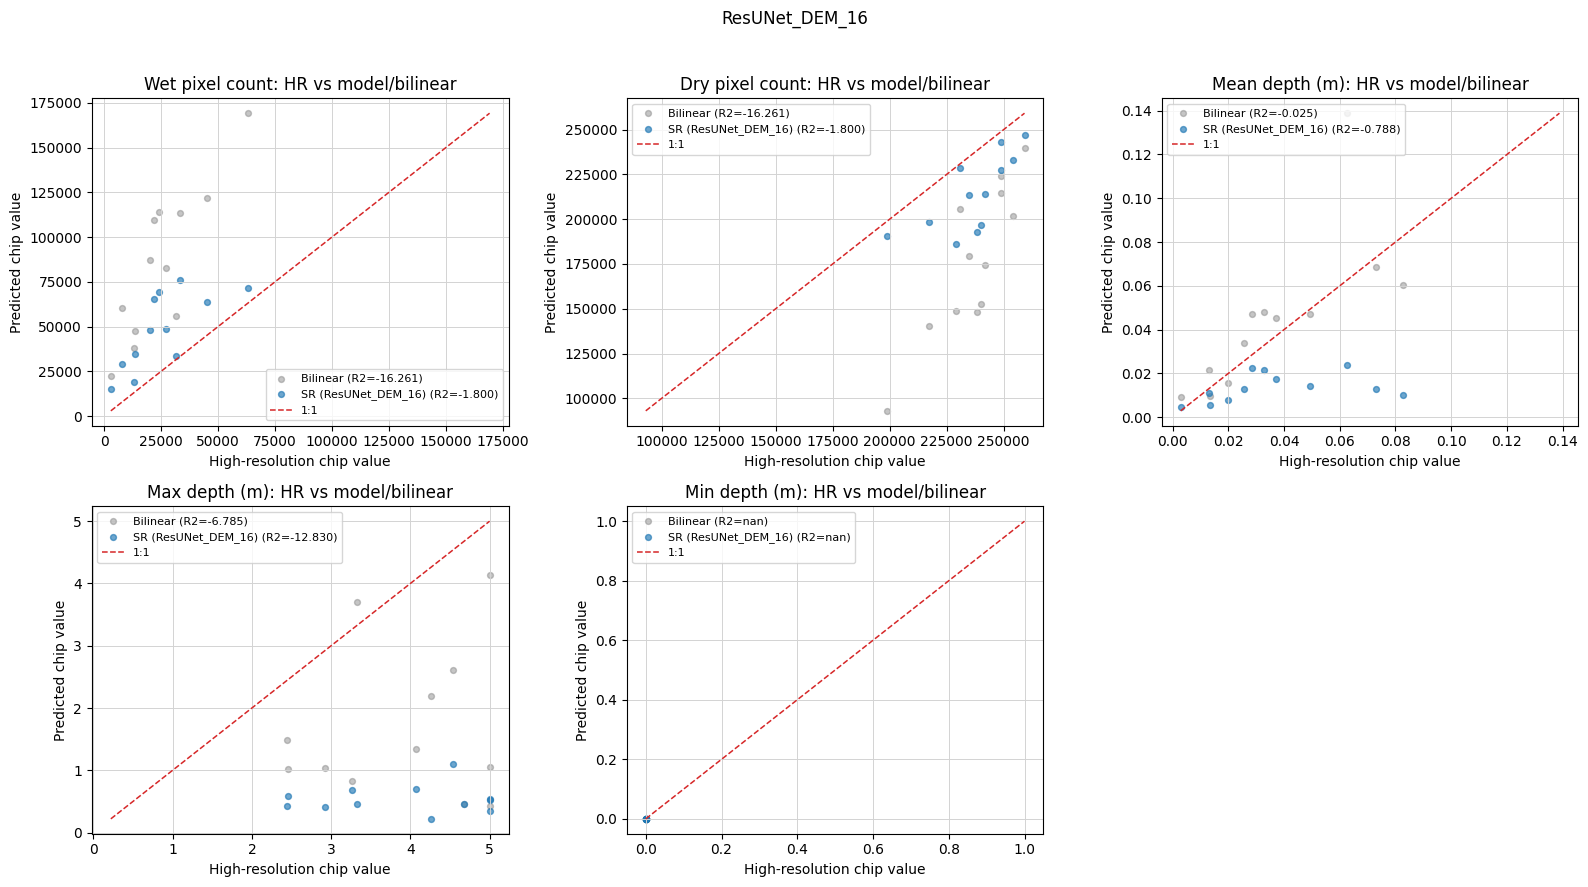

In [17]:

fig_chip_scatter, _ = results.plot_chip_stat_scatter(
    test_samples,
    model_label=MODEL_SERIES_LABEL,
    baseline_label='Bilinear',
    model_name=MODEL_NAME,
)
plt.show()
plt.close(fig_chip_scatter)


Scanned test chips: 12
Retained candidate chips in memory: 6

Worst chips (highest SR MAE):


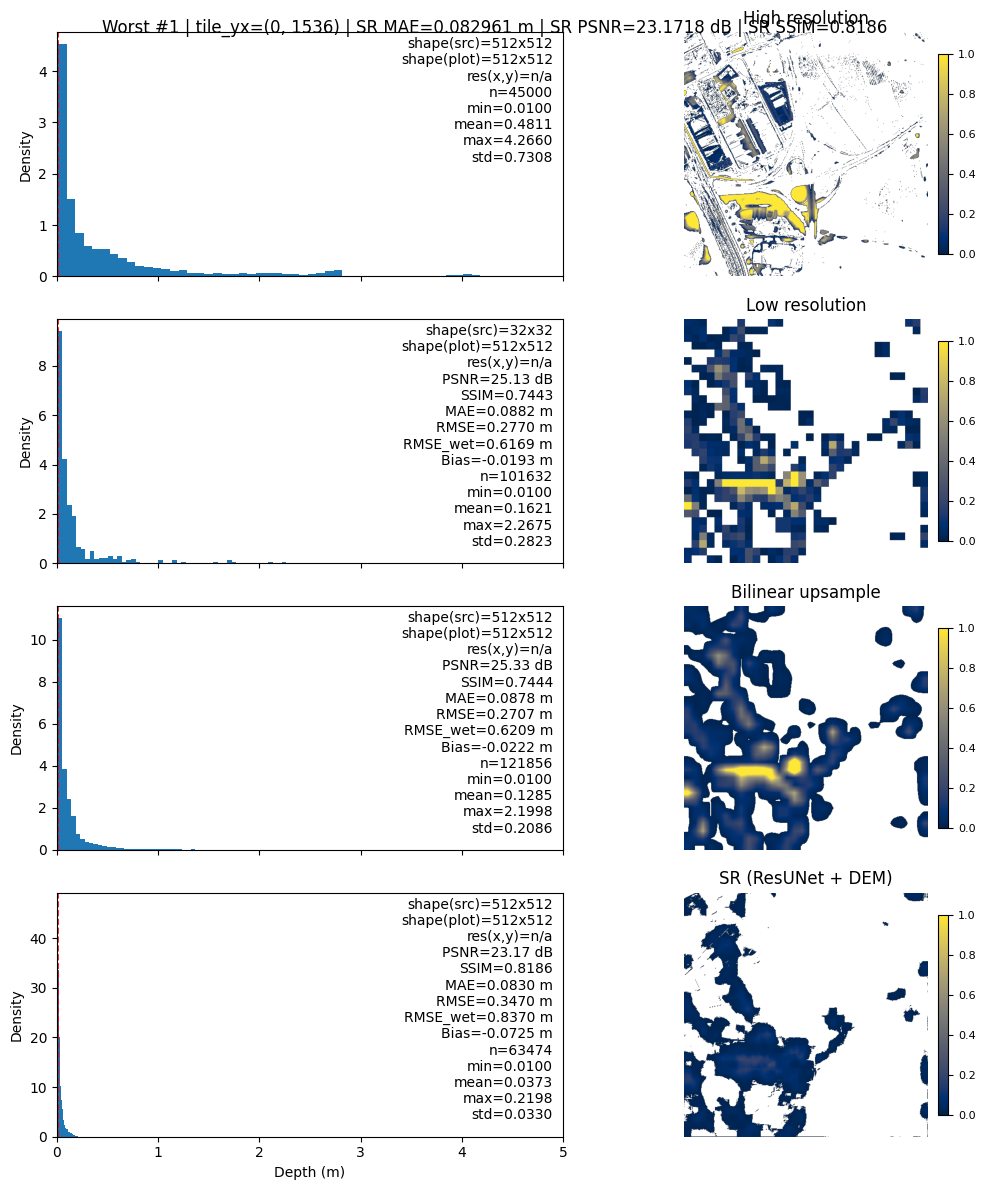

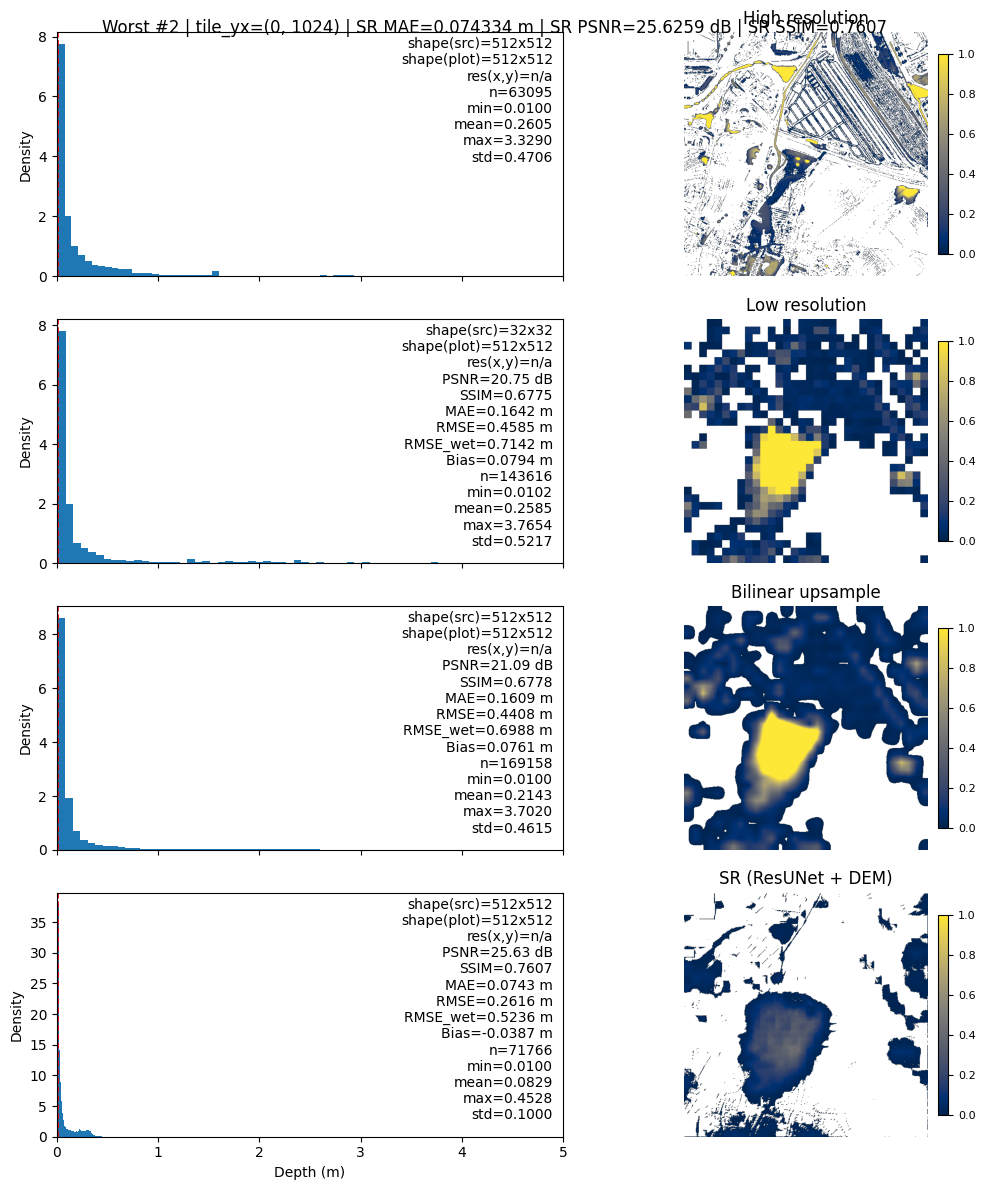

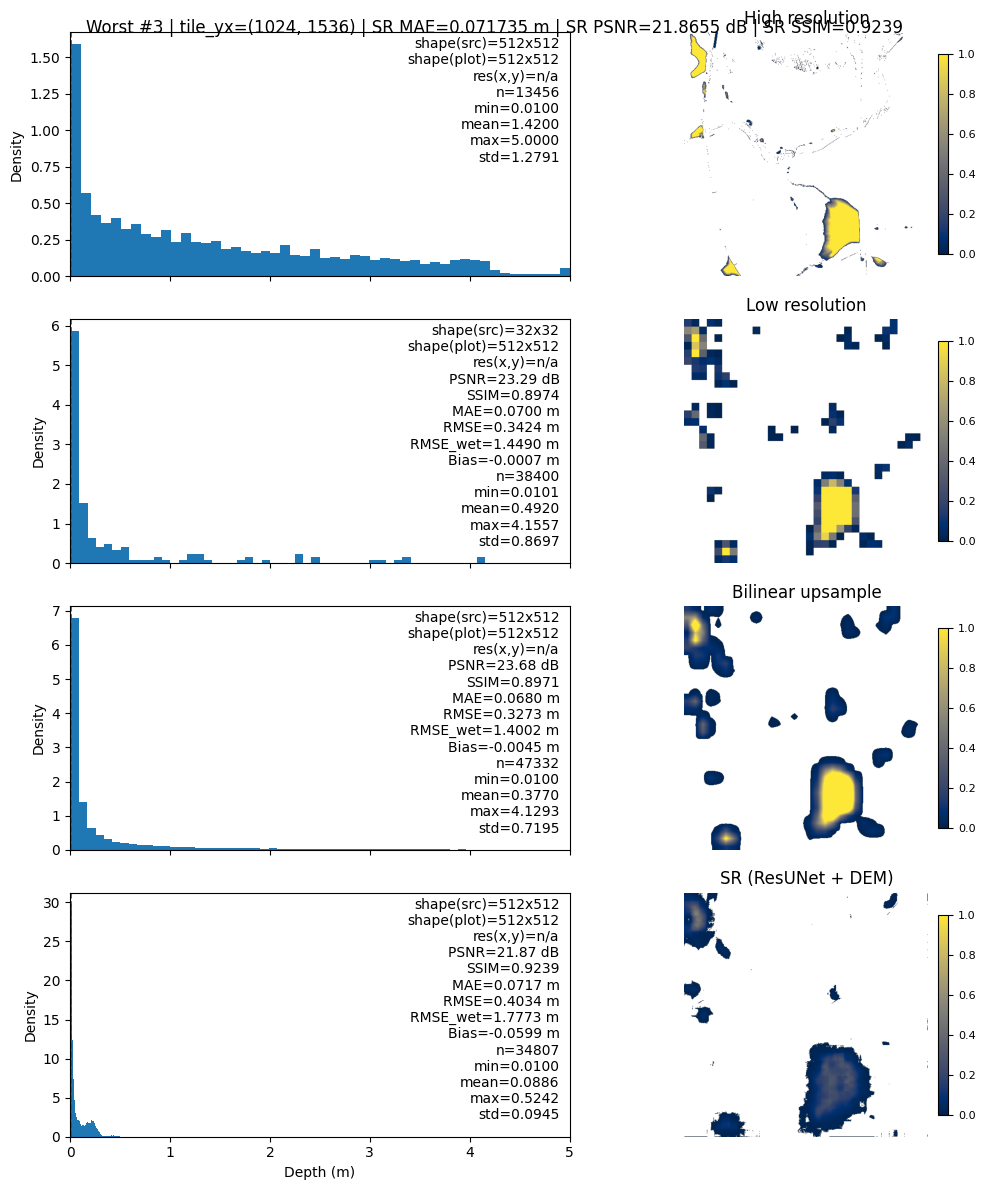


Best chips (lowest SR MAE):


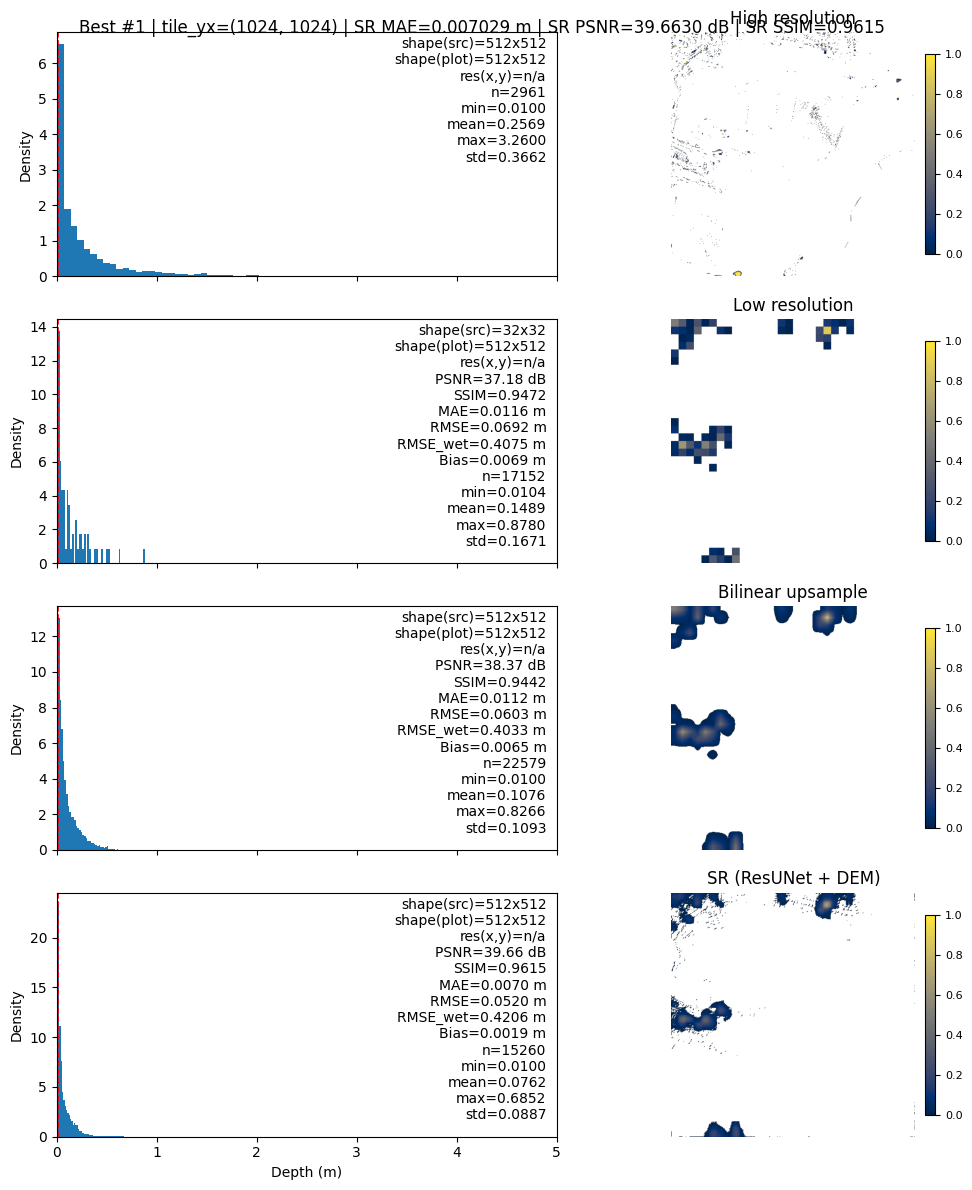

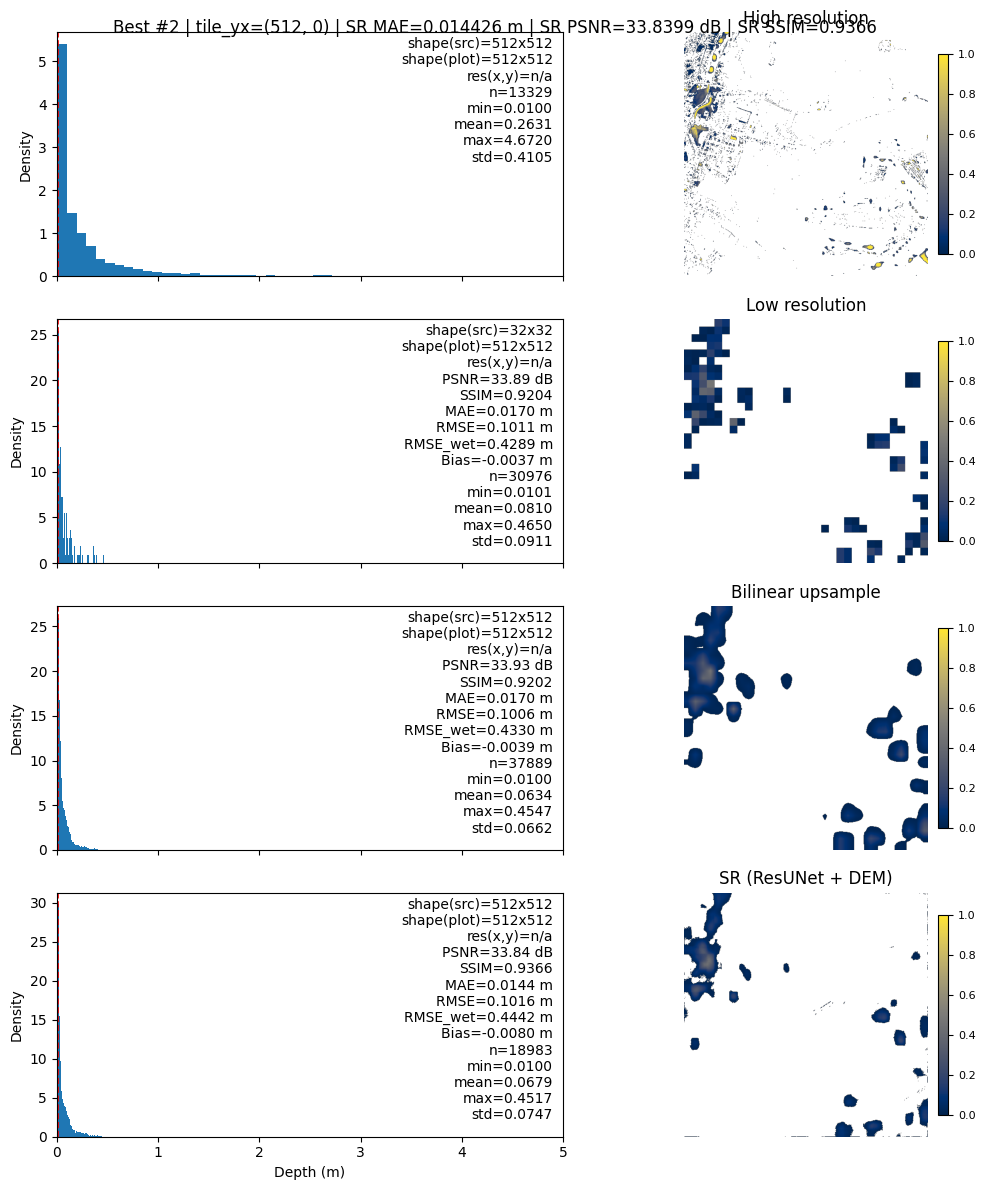

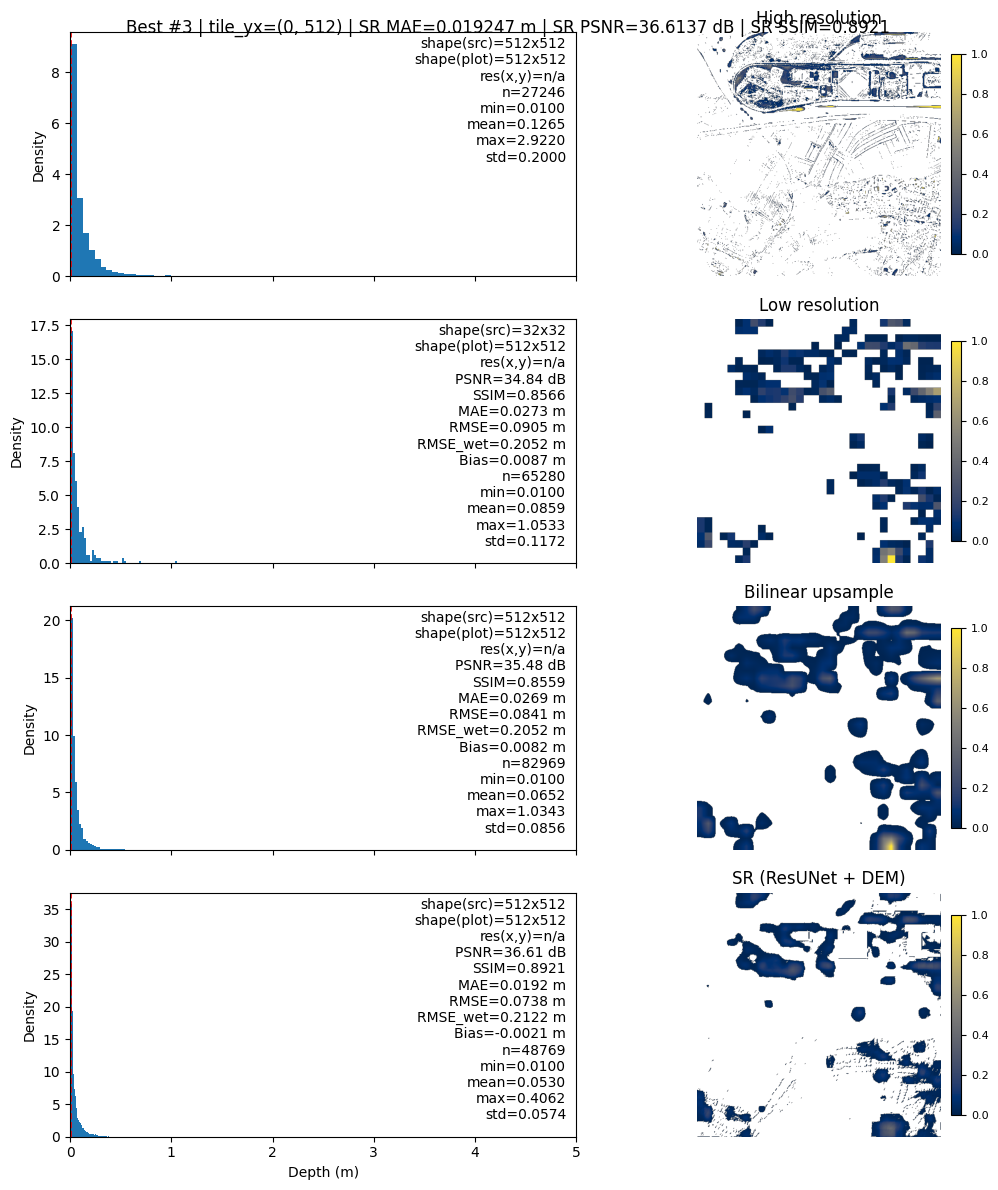

In [18]:

_ = results.plot_best_worst_chip_examples(
    lowres_chips=lowres_chips,
    highres_chips=highres_chips,
    preds_chips=preds_chips,
    max_depth=MAX_DEPTH,
    n_show=3,
    dry_depth_thresh_m=DRY_DEPTH_THRESH_M,
    cmap='cividis',
    chip_ids=chip_coords,
)



In [19]:
# Step 2: build final mosaic while reusing cached tile predictions.
if WINDOW_METHOD == "hard":
    # Hard mosaicing: use only non-overlap pass output (fast, but can show seams).
    sr_pad = sr_pad_nonoverlap.copy()
    print(
        f"Mosaicing with WINDOW_METHOD='hard' using cached chips only "
        f"({len(tile_pred_cache)} predictions cached)."
    )

elif WINDOW_METHOD == "feather":
    # Feather mosaicing: overlap tiles and blend them with tapering edge weights.
    overlap_hr = FEATHER_OVERLAP_LR * SCALE
    stride_hr = HR_TILE - overlap_hr

    if stride_hr <= 0:
        raise AssertionError(
            f"Feather stride must be > 0; got stride_hr={stride_hr} from FEATHER_OVERLAP_LR={FEATHER_OVERLAP_LR}"
        )

    # Build overlapping tile origins that still guarantee full-edge coverage.
    y_starts = build_tile_starts(hr_pad_h, HR_TILE, stride_hr)
    x_starts = build_tile_starts(hr_pad_w, HR_TILE, stride_hr)

    # Build a symmetric 1D ramp weight used along each tile axis.
    feather_1d = np.ones(HR_TILE, dtype=np.float32)
    if overlap_hr > 0:
        ramp = np.linspace(0.0, 1.0, overlap_hr + 2, dtype=np.float32)[1:-1]
        feather_1d[:overlap_hr] = ramp
        feather_1d[-overlap_hr:] = ramp[::-1]
    feather_1d = np.clip(feather_1d, 1e-3, 1.0)

    # Accumulate weighted predictions then divide by total weight per pixel.
    accum = np.zeros_like(hr_pad, dtype=np.float32)
    weight_sum = np.zeros_like(hr_pad, dtype=np.float32)

    print(
        f"Mosaicing with WINDOW_METHOD='feather' using {len(y_starts) * len(x_starts)} windows "
        f"(overlap={overlap_hr} px, stride={stride_hr} px)..."
    )

    for yi, y0 in enumerate(y_starts):
        for xi, x0 in enumerate(x_starts):
            pred_np = _predict_tile(y0, x0)

            # Start from base ramp and flatten exterior borders to avoid dimming scene edges.
            wy = feather_1d.copy()
            wx = feather_1d.copy()

            if yi == 0:
                wy[:overlap_hr] = 1.0
            if yi == len(y_starts) - 1:
                wy[-overlap_hr:] = 1.0
            if xi == 0:
                wx[:overlap_hr] = 1.0
            if xi == len(x_starts) - 1:
                wx[-overlap_hr:] = 1.0

            # Use separable outer-product weights for efficient 2D blending.
            weight = np.outer(wy, wx).astype(np.float32, copy=False)
            accum[y0 : y0 + HR_TILE, x0 : x0 + HR_TILE] += pred_np * weight
            weight_sum[y0 : y0 + HR_TILE, x0 : x0 + HR_TILE] += weight

    sr_pad = np.divide(
        accum,
        np.maximum(weight_sum, 1e-6),
        out=np.zeros_like(accum),
        where=weight_sum > 0,
    )
    print(f"Cached predictions after feather mosaicing: {len(tile_pred_cache)}")

else:
    raise ValueError(f"Unsupported WINDOW_METHOD: {WINDOW_METHOD!r}")


# Crop away padding and keep normalized prediction range bounded.
sr = np.clip(sr_pad[:crop_h, :crop_w], 0.0, 1.0)
hr_valid = hr_raw[:crop_h, :crop_w]
print("SR shape:", sr.shape)


Mosaicing with WINDOW_METHOD='feather' using 35 windows (overlap=128 px, stride=384 px)...
Cached predictions after feather mosaicing: 49
SR shape: (2016, 2080)


In [20]:
# Export prediction as GeoTIFF in depth units (meters).
ofp = model_fp.parent / depth_lores_fp.name.replace('.tif', '_SR.tif')


ofp.parent.mkdir(parents=True, exist_ok=True)

# Convert model output from normalized log-space back to depth (meters).
sr_depth_m = invert_depth_log1p_np(sr, max_depth=MAX_DEPTH)

if write_inference_tiff:
    print(f"Saving SR result to {ofp}...")
    out_profile = hr_profile.copy()
    out_profile.update(
        dtype=rasterio.float32,
        count=1,
        compress='deflate',
        height=sr_depth_m.shape[0],
        width=sr_depth_m.shape[1],
    )
    with rasterio.open(ofp, 'w', **out_profile) as dst:
        dst.write(sr_depth_m.astype(np.float32), 1)

    print(
        f"Saved depth raster in meters. Range: min={float(np.nanmin(sr_depth_m)):.4f}, max={float(np.nanmax(sr_depth_m)):.4f}"
    )
else:
    print(
        f"WRITE_INFERENCE_TIFF=0; skipped writing {ofp}. Depth range: min={float(np.nanmin(sr_depth_m)):.4f}, max={float(np.nanmax(sr_depth_m)):.4f}"
    )


Saving SR result to train_outputs/4690176_0_1770580046_train_base_16/train_run/ResultA_SR.tif...
Saved depth raster in meters. Range: min=0.0000, max=1.8685


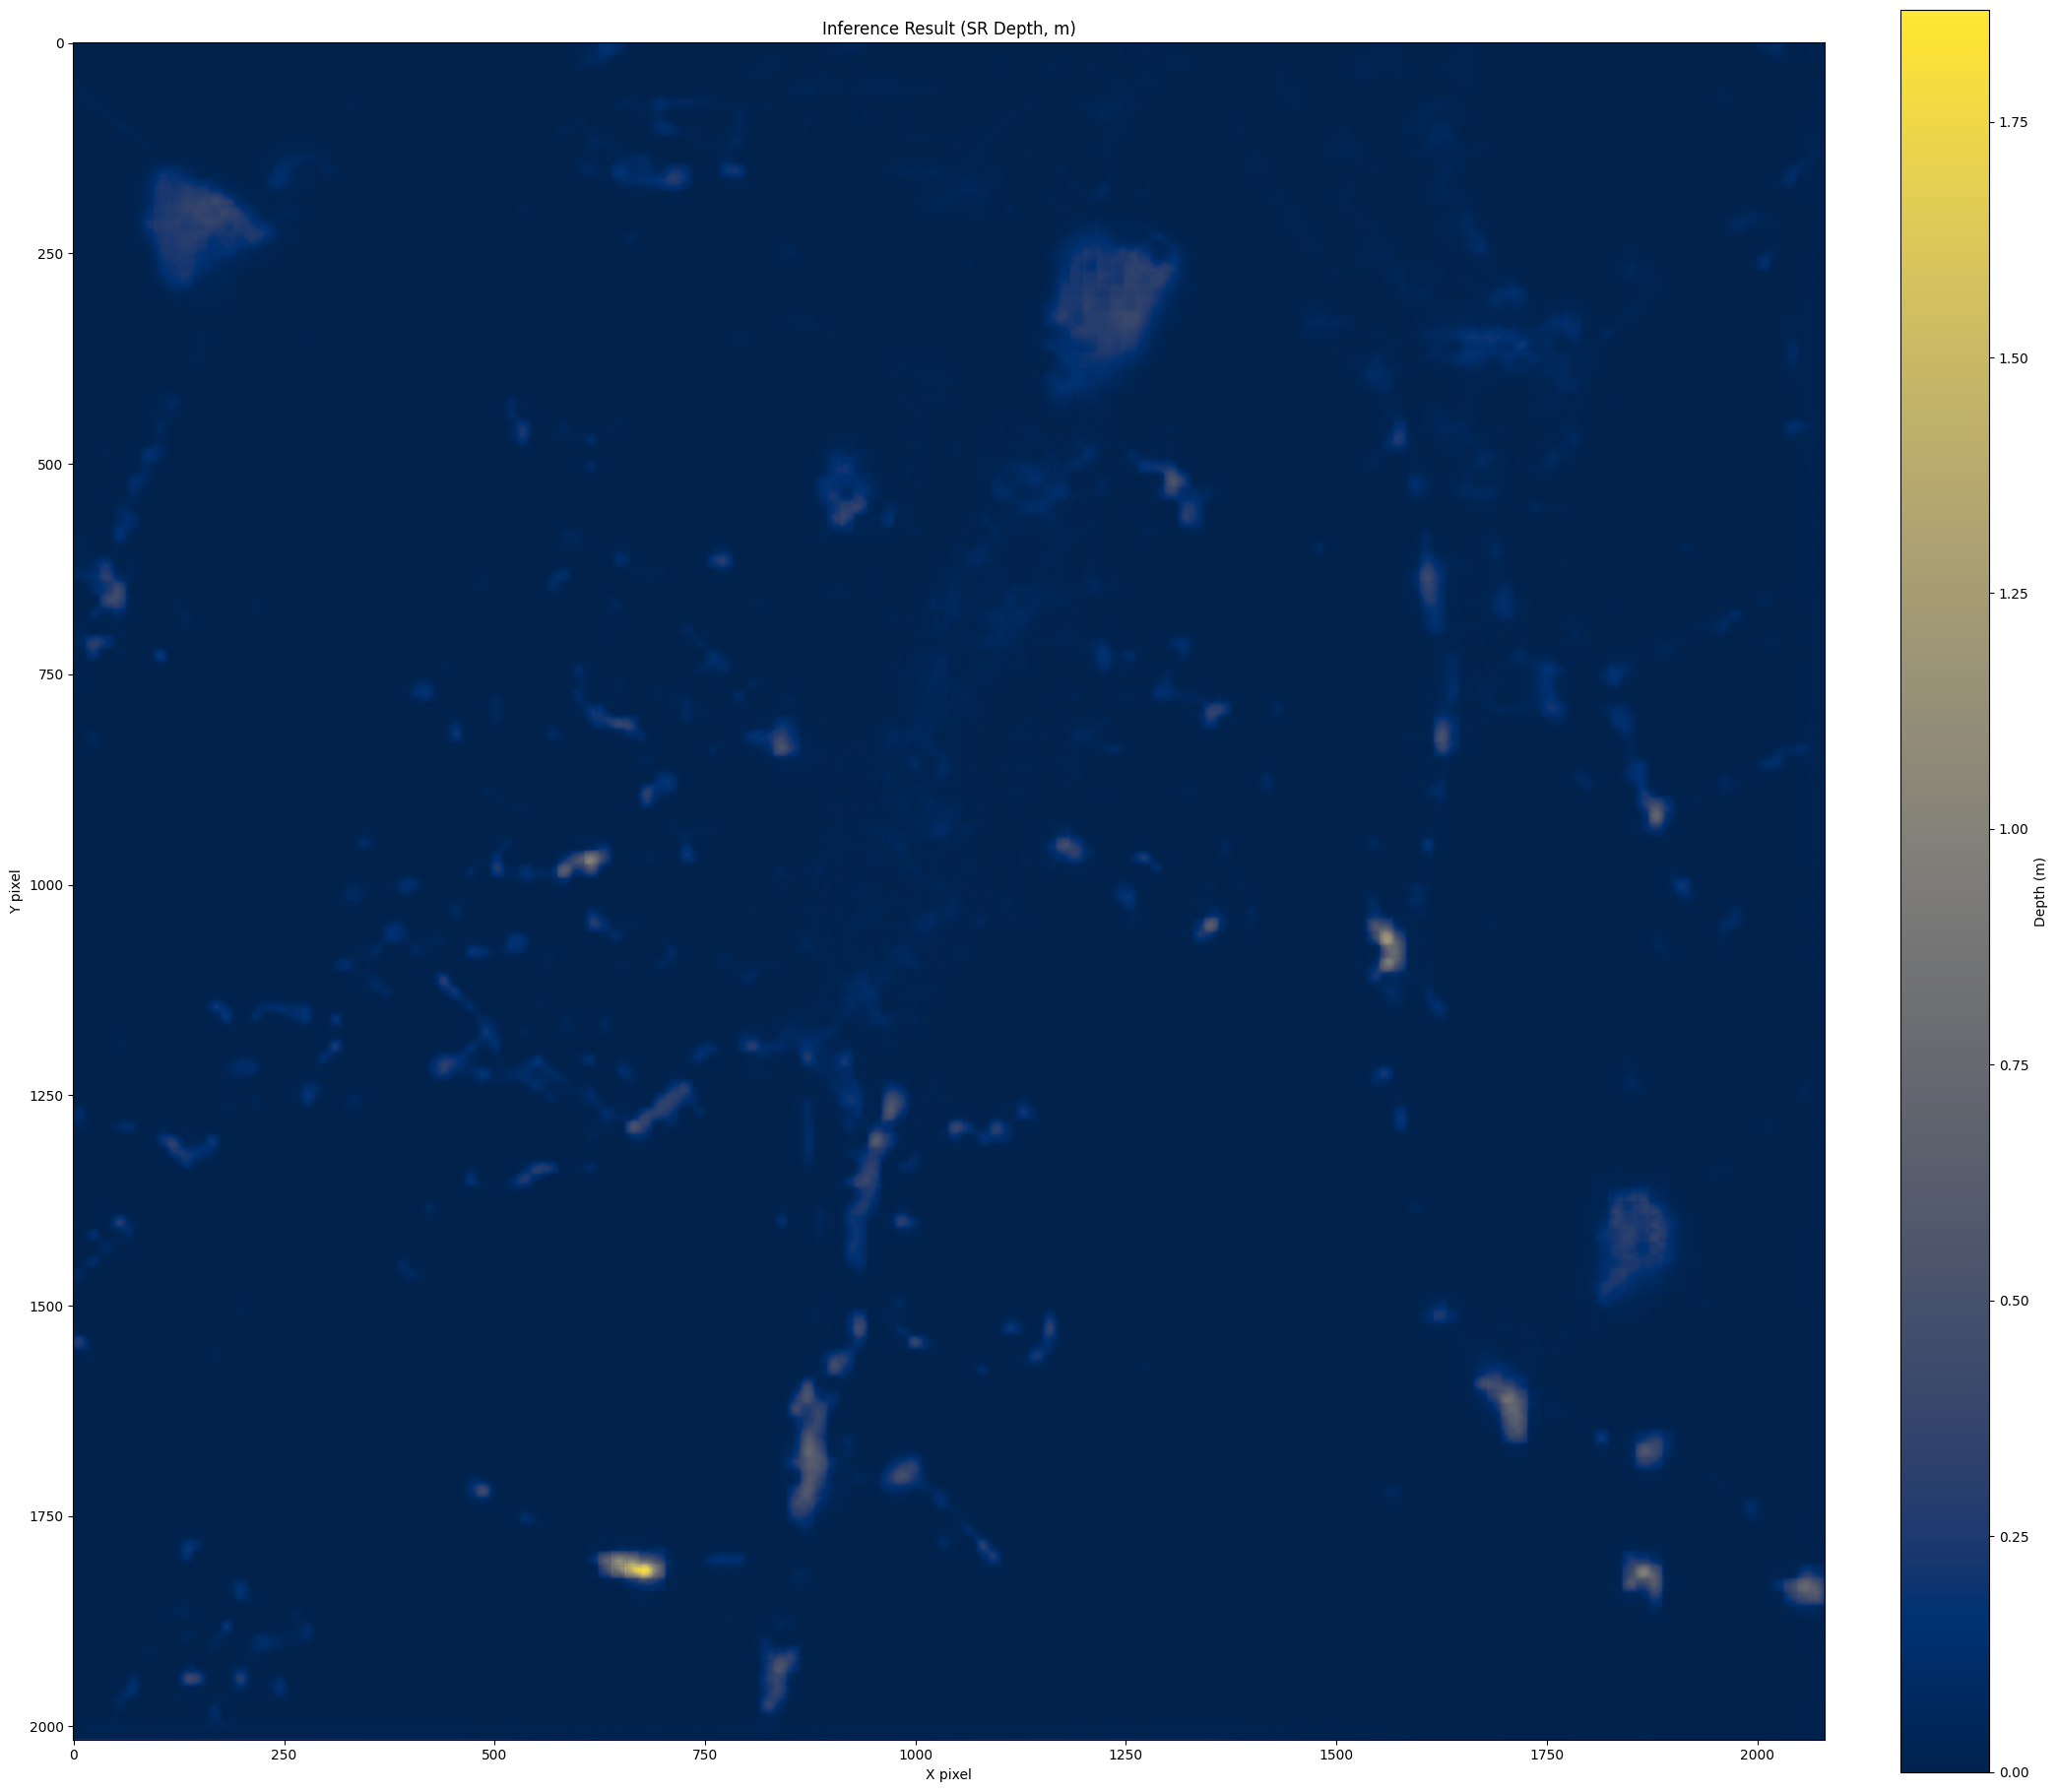

In [21]:
# Preview the inferred depth raster (meters).
fig, ax = plt.subplots(figsize=(21, 21))
im = ax.imshow(sr_depth_m, cmap='cividis')
ax.set_title('Inference Result (SR Depth, m)')
ax.set_xlabel('X pixel')
ax.set_ylabel('Y pixel')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Depth (m)')
plt.tight_layout()
plt.show()


# Bilinear baseline + mosaic-level metrics


In [22]:
# Build a bilinear baseline from LR input and compare against HR target.
baseline_shape_scale = (hr_pad_h / lr_pad.shape[0], hr_pad_w / lr_pad.shape[1])
baseline_res_scale = (lr_res_model[0] / hr_res[0], lr_res_model[1] / hr_res[1])
print("Full-scene bilinear baseline geometry:")
print(f"  pre shapes LR/HR (padded): {lr_pad.shape} / {hr_pad.shape}")
print(f"  pre resolutions LR/HR: {_fmt_res(lr_res_model)} / {_fmt_res(hr_res)}")
print(f"  pre scale from shape (h,w): ({baseline_shape_scale[0]:.2f}, {baseline_shape_scale[1]:.2f})")
print(f"  pre scale from resolution (x,y): ({baseline_res_scale[0]:.2f}, {baseline_res_scale[1]:.2f})")

baseline_pad = resize_bilinear_2d_np(lr_pad, (hr_pad_h, hr_pad_w), antialias=True)
baseline = np.clip(baseline_pad[:crop_h, :crop_w], 0.0, 1.0)
print(f"  post bilinear shape (padded->valid): {baseline_pad.shape} -> {baseline.shape}")
print(f"  post bilinear resolution: {_fmt_res(hr_res)}")


# Compute mosaic-level metrics in normalized space with shared helpers.
hr_full = tf.convert_to_tensor(hr_valid[None, ..., None], dtype=tf.float32)
sr_full = tf.convert_to_tensor(sr[None, ..., None], dtype=tf.float32)
bl_full = tf.convert_to_tensor(baseline[None, ..., None], dtype=tf.float32)

sr_metric_tensors = results.compute_per_sample_metrics(hr_full, sr_full)
bl_metric_tensors = results.compute_per_sample_metrics(hr_full, bl_full)

metrics_sr = results.reduce_metric_buffers({k: [v] for k, v in sr_metric_tensors.items()})
metrics_bilinear = results.reduce_metric_buffers({k: [v] for k, v in bl_metric_tensors.items()})

df = pd.DataFrame({
    'ResUNet': metrics_sr,
    'Bilinear': metrics_bilinear,
})
df = df.loc[list(results.METRIC_KEYS), ['ResUNet', 'Bilinear']]
df['delta'] = df['ResUNet'] - df['Bilinear']
df.round(4)


Full-scene bilinear baseline geometry:
  pre shapes LR/HR (padded): (128, 160) / (2048, 2560)
  pre resolutions LR/HR: (48, 48) / (3, 3)
  pre scale from shape (h,w): (16.00, 16.00)
  pre scale from resolution (x,y): (16.00, 16.00)
  post bilinear shape (padded->valid): (2048, 2560) -> (2016, 2080)
  post bilinear resolution: (3, 3)


ResUNet  Bilinear   delta
MAE              0.0142    0.0190 -0.0048
PSNR            24.3257   24.0399  0.2858
SSIM             0.8223    0.7612  0.0611
RMSE             0.0608    0.0628 -0.0020
RMSE_wet_001cm   0.2175    0.1854  0.0320
RMSE_wet_050cm   0.5892    0.4523  0.1369
RMSE_wet_100cm      NaN       NaN     NaN
CSI_001cm        0.2417    0.2194  0.0223
CSI_050cm        0.0036    0.1183 -0.1147
CSI_100cm        0.0000    0.0000  0.0000

# PLOT Inference (mosaic-level)


Full-scene inference diagnostics


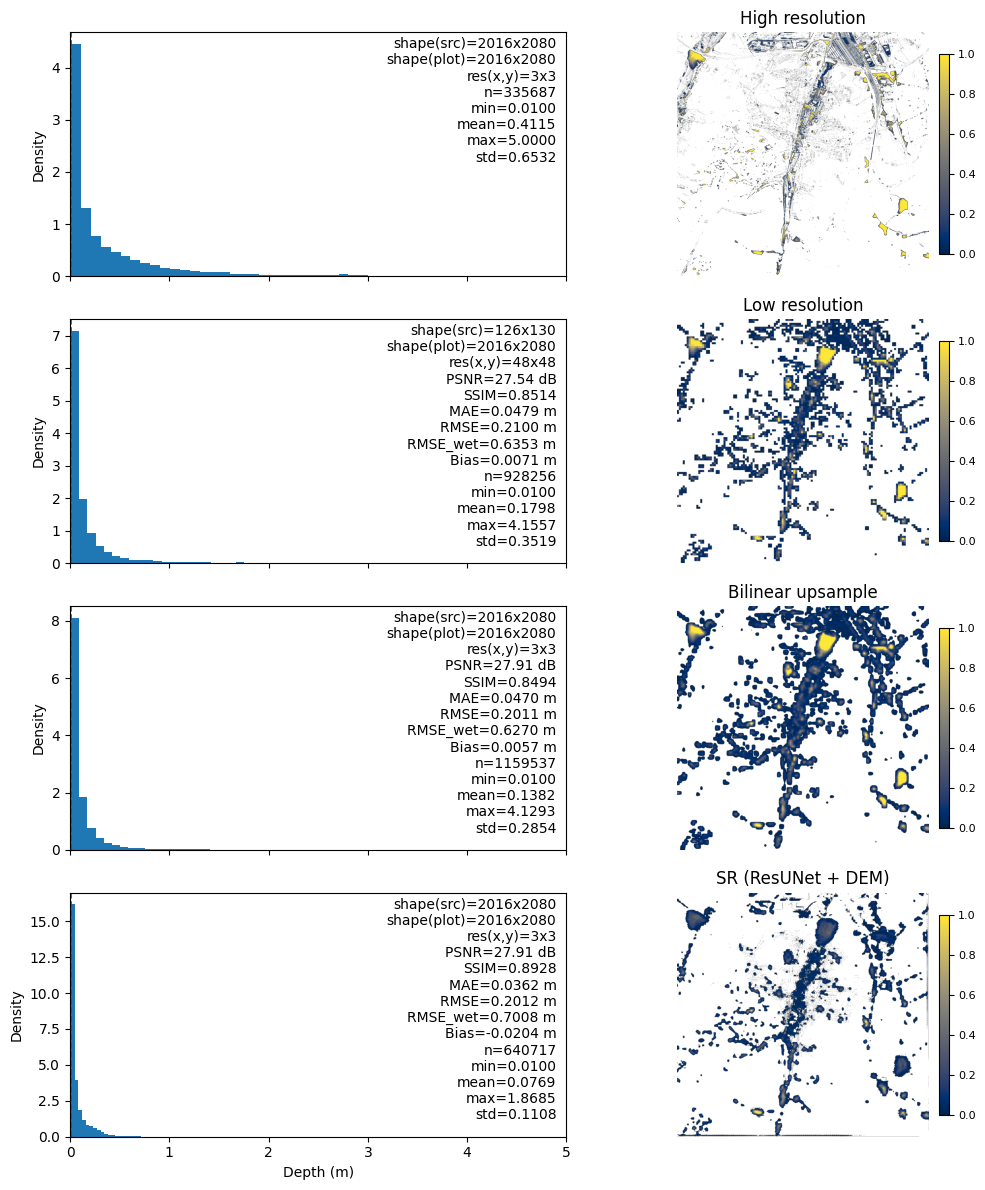

PSNR between LR and HR image full-scene: 27.5354
SSIM between LR and HR image full-scene: 0.8514
PSNR between HR and SR image full-scene: 27.9068
SSIM between HR and SR image full-scene: 0.8928
MAE between HR and SR image full-scene: 0.036211 m


{'lr_psnr': 27.535358428955078,
 'lr_ssim': 0.8513750433921814,
 'lr_mae_m': 0.047892145812511444,
 'lr_rmse_m': 0.20999164879322052,
 'lr_rmse_wet_m': 0.6353119015693665,
 'lr_bias_m': 0.007093407679349184,
 'lr_wet_pixel_count': 335687,
 'lr_dry_pixel_count': 3857593,
 'sr_psnr': 27.90679931640625,
 'sr_ssim': 0.8928460478782654,
 'sr_mae_m': 0.03621072322130203,
 'sr_rmse_m': 0.2012009471654892,
 'sr_rmse_wet_m': 0.7007544636726379,
 'sr_bias_m': -0.020405160263180733,
 'sr_wet_pixel_count': 335687,
 'sr_dry_pixel_count': 3857593,
 'hr_wet_pixel_count': 335687,
 'hr_dry_pixel_count': 3857593,
 'hr_mean_depth_m': 0.032979171723127365,
 'hr_max_depth_m': 5.0,
 'hr_min_depth_m': 0.0,
 'bl_psnr': 27.909456253051758,
 'bl_ssim': 0.8493820428848267,
 'bl_mae_m': 0.046983927488327026,
 'bl_rmse_m': 0.2011394053697586,
 'bl_rmse_wet_m': 0.6269723773002625,
 'bl_bias_m': 0.0056741987355053425,
 'bl_wet_pixel_count': 335687,
 'bl_dry_pixel_count': 3857593}

In [23]:
# Final full-scene diagnostics in depth units (meters).
# Plot final full-scene inference with shared depth-domain metrics and histograms.

DRY_DEPTH_THRESH_PLOT_M = DRY_DEPTH_THRESH_M

full_lr = tf.convert_to_tensor(lr_norm[..., None], dtype=tf.float32)
full_hr = tf.convert_to_tensor(hr_valid[..., None], dtype=tf.float32)
full_sr = tf.convert_to_tensor(sr[..., None], dtype=tf.float32)

print("Full-scene inference diagnostics")
fig, final_metrics = results.plot_chip_comparison(
    highres=full_hr,
    lowres=full_lr,
    preds=full_sr,
    max_depth=MAX_DEPTH,
    dry_depth_thresh_m=DRY_DEPTH_THRESH_PLOT_M,
    cmap="cividis",
    lowres_resolution=lr_res_model,
    highres_resolution=hr_res,
)
plt.show()
plt.close(fig)

tile_label = "full-scene"
print("PSNR between LR and HR image {}: {:.4f}".format(tile_label, final_metrics["lr_psnr"]))
print("SSIM between LR and HR image {}: {:.4f}".format(tile_label, final_metrics["lr_ssim"]))
print("PSNR between HR and SR image {}: {:.4f}".format(tile_label, final_metrics["sr_psnr"]))
print("SSIM between HR and SR image {}: {:.4f}".format(tile_label, final_metrics["sr_ssim"]))
print("MAE between HR and SR image {}: {:.6f} m".format(tile_label, final_metrics["sr_mae_m"]))

final_metrics
